Aqui montaremos a rede para avaliar os dados para a tarefa de classificação multiclasse com a extração de características hog (Histogram of Oriented Gradients)

## Integrantes

- Elisa Yea Ji Lee - NUSP 11892473
- João Victor Andrade Lúcio - NUSP 11207877
- Leonardo Zoppello Fernandes - NUSP 13838749
- Marcos Paulo Tomás Ferreira - NUSP 13747950
- Rafael Moura de Almeida - NUSP 11225505
- Thomas Delfs - NUSP 13837175

Importar as bibliotecas e os dados do conjunto MNIST

In [1]:
import json
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import mnist
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler

# 1. Carregar o conjunto de dados MNIST
(x_train, y_train), (x_test, y_test) = mnist.load_data()

Criando a função que implementa o descritor HOG

In [2]:
def extract_hog_features(images):
    features = []
    for image in images:
        fd = hog(image, orientations=8, pixels_per_cell=(4, 4), cells_per_block=(1, 1), visualize=False)
        features.append(fd)
    return np.array(features)

Normalizando os dados. As imagens já vem em escala de cinza.

In [3]:
x_train = x_train / 255.0
x_test = x_test / 255.0

Extraír as características HOG do conjunto

In [4]:
x_train_hog = extract_hog_features(x_train)
x_test_hog = extract_hog_features(x_test)

Normalizando as características HOG extraídas

In [5]:
scaler = StandardScaler()
x_train_hog = scaler.fit_transform(x_train_hog)
x_test_hog = scaler.transform(x_test_hog)

Redimensionando os dados normalizados, extraídos com HOG, para o formato esperado pela CNN

In [6]:
x_train_hog = x_train_hog.reshape(x_train_hog.shape[0], 1, 1, x_train_hog.shape[1])
x_test_hog = x_test_hog.reshape(x_test_hog.shape[0], 1, 1, x_test_hog.shape[1])

Converter os rótulos para one-hot encoding

`to_categorical(rótulos, número de classes)`

In [7]:
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

Construir o modelo

In [8]:
model = Sequential([
    Flatten(input_shape=(x_train_hog.shape[1], x_train_hog.shape[2], x_train_hog.shape[3])),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dense(10, activation='softmax')
])

c:\Users\mtoma\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Compilar o modelo

In [9]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

- Criando e salvando os hiperparâmetros da arquitetura e da inicialização em formato json em arquivos-hog/hiperparametros.json

- Salvando os pesos iniciais

In [10]:
# Definindo os hiperparâmetros
hiperparametros = {
    "arquitetura": {
        "camadas": [64, 64, 10],
        "ativacao": "relu",
        "ultimo_ativacao": "softmax"
    },
    "inicializacao": {
        "pesos": "he_normal",
        "bias": "zeros"
    }
}

# Serializando os hiperparâmetros em uma string JSON
hiperparametros_json = json.dumps(hiperparametros, indent=4)

# Escrevendo a string JSON em um arquivo
with open("arquivos-hog/hiperparametros.json", "w") as arquivo:
    arquivo.write(hiperparametros_json)


# PESOS INICIAIS
model.save_weights('arquivos-hog/pesos_iniciais.weights.h5')

Treinar o modelo

In [11]:
historico = model.fit(x_train_hog, y_train, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8170 - loss: 0.5996 - val_accuracy: 0.9682 - val_loss: 0.1107
Epoch 2/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9538 - loss: 0.1513 - val_accuracy: 0.9742 - val_loss: 0.0906
Epoch 3/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9619 - loss: 0.1280 - val_accuracy: 0.9744 - val_loss: 0.1015
Epoch 4/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9695 - loss: 0.0990 - val_accuracy: 0.9757 - val_loss: 0.0932
Epoch 5/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9711 - loss: 0.0947 - val_accuracy: 0.9771 - val_loss: 0.0947
Epoch 6/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.9718 - loss: 0.0895 - val_accuracy: 0.9768 - val_loss: 0.1031
Epoch 7/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.9743 - loss: 0.0807 - val_accuracy: 0.9765 - val_loss: 0.1071
Epoch 8/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.9759 - loss: 0.0773 - 

- Salvando os pesos finais da rede 
- Salvando o histórico de perda para cada iteração
- Salvando as saídas produzidas pela rede para cada um dos dados de teste

In [12]:
# PESOS FINAIS
model.save_weights('arquivos-hog/pesos_finais.weights.h5')

# ERRO DE CADA ITERAÇÃO
perdas = historico.history['loss']

# Salvando o histórico de perda em um arquivo JSON
with open('arquivos-hog/historico_perda.json', 'w') as f:
    json.dump(perdas, f)


# SAÍDAS PRODUZIDAS
# Fazendo inferência com o modelo treinado para obter as saídas
saidas = model.predict(x_test_hog)

# Convertendo as saídas para uma lista para serialização
saidas_lista = saidas.tolist()

# Salvando as saídas em um arquivo JSON
with open('arquivos-hog/saidas_teste.json', 'w') as f:
    json.dump(saidas_lista, f)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


Calculando a matriz de confusão

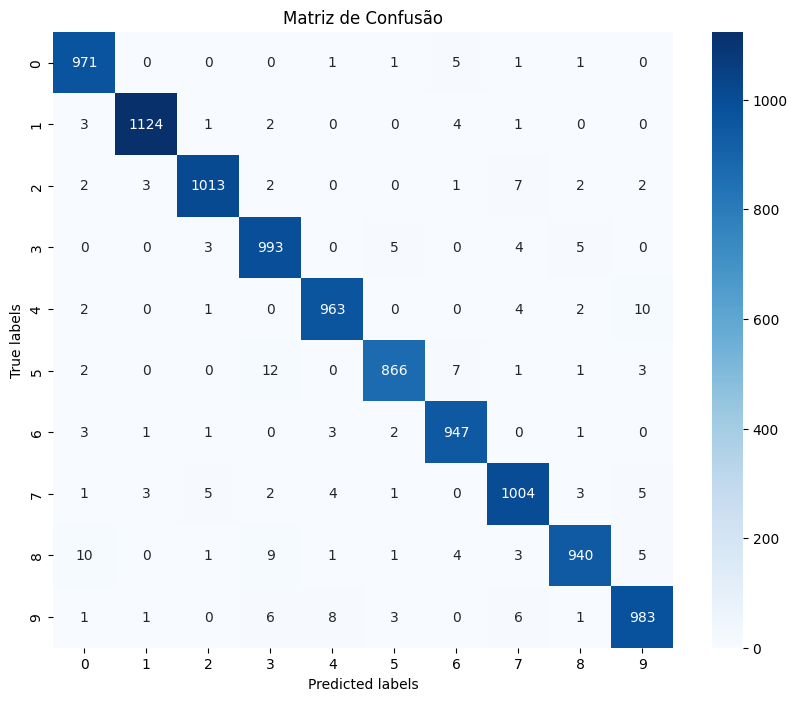

In [13]:
# Previsões
classes_previstas = np.argmax(saidas, axis=1)
classes_verdadeiras = np.argmax(y_test, axis=1)

# Calcule a matriz de confusão
cm = confusion_matrix(classes_verdadeiras, classes_previstas)

# Plot a matriz de confusão
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Matriz de Confusão')
plt.show()

Testar o modelo

In [14]:
test_loss, test_acc = model.evaluate(x_test_hog, y_test)
print(f'Test accuracy: {test_acc}, Test loss: {test_loss}')

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9770 - loss: 0.0795
Test accuracy: 0.980400025844574, Test loss: 0.07040797173976898
